# Fashion MNIST with Keras

## Dataset

In [1]:
from keras.datasets import fashion_mnist
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()

Using TensorFlow backend.


## Model

In [2]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

class MiniVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
            
        # first CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(32, (3, 3), padding="same",
                         input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # second CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        # return the constructed network architecture
        return model

In [3]:
from sklearn.metrics import classification_report
from keras.optimizers import SGD
from keras.datasets import fashion_mnist
from keras.utils import np_utils
from keras import backend as K

import matplotlib.pyplot as plt
import numpy as np
import cv2

In [4]:
# initialize the number of epochs to train for, base learning rate,
# and batch size
NUM_EPOCHS = 25
INIT_LR = 1e-2
BS = 1024

In [5]:
# if we are using "channels first" ordering, then reshape the design
# matrix such that the matrix is:
# num_samples x depth x rows x columns
if K.image_data_format() == "channels_first":
    trainX = trainX.reshape((trainX.shape[0], 1, 28, 28))
    testX = testX.reshape((testX.shape[0], 1, 28, 28))
    
# otherwise, we are using "channels last" ordering, so the design
# matrix shape should be: num_samples x rows x columns x depth
else:
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))

## Preprocess + Prepare

In [6]:
# scale data to the range of [0, 1]
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0
# one-hot encode the training and testing labels
trainY = np_utils.to_categorical(trainY, 10)
testY = np_utils.to_categorical(testY, 10)
# initialize the label names
labelNames = ["top", "trouser", "pullover", "dress", "coat",
              "sandal", "shirt", "sneaker", "bag", "ankle boot"]

## Initialize the optimizer and model

In [7]:
opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
model = MiniVGGNet.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

W0525 14:49:31.182587 140469793027840 deprecation_wrapper.py:119] From /home/thangdn/anaconda3/envs/duan/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0525 14:49:31.183961 140469793027840 deprecation_wrapper.py:119] From /home/thangdn/anaconda3/envs/duan/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0525 14:49:31.185502 140469793027840 deprecation_wrapper.py:119] From /home/thangdn/anaconda3/envs/duan/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0525 14:49:31.203301 140469793027840 deprecation_wrapper.py:119] From /home/thangdn/anaconda3/envs/duan/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprec

## Train the network

In [8]:
H = model.fit(trainX, trainY,
              validation_data=(testX, testY),
              batch_size=BS, epochs=NUM_EPOCHS)

W0525 14:49:32.678565 140469793027840 deprecation.py:323] From /home/thangdn/anaconda3/envs/duan/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 5s 90us/step - loss: 0.8424 - acc: 0.7277 - val_loss: 0.4562 - val_acc: 0.8360
Epoch 2/25
60000/60000 [==============================] - 3s 44us/step - loss: 0.4548 - acc: 0.8363 - val_loss: 0.3526 - val_acc: 0.8710
Epoch 3/25
60000/60000 [==============================] - 3s 44us/step - loss: 0.3933 - acc: 0.8561 - val_loss: 0.3546 - val_acc: 0.8653
Epoch 4/25
60000/60000 [==============================] - 3s 44us/step - loss: 0.3584 - acc: 0.8698 - val_loss: 0.2993 - val_acc: 0.8897
Epoch 5/25
60000/60000 [==============================] - 3s 44us/step - loss: 0.3350 - acc: 0.8792 - val_loss: 0.2981 - val_acc: 0.8904
Epoch 6/25
60000/60000 [==============================] - 3s 44us/step - loss: 0.3165 - acc: 0.8839 - val_loss: 0.2831 - val_acc: 0.8972
Epoch 7/25
60000/60000 [==============================] - 3s 44us/step - loss: 0.3032 - acc: 0.8896 - val_loss: 0.2696 - val_acc

## Test

In [9]:
preds = model.predict(testX)
# show a nicely formatted classification report
print("[INFO] evaluating network...")
print(classification_report(testY.argmax(axis=1), preds.argmax(axis=1),
                            target_names=labelNames))

[INFO] evaluating network...
              precision    recall  f1-score   support

         top       0.86      0.90      0.88      1000
     trouser       1.00      0.98      0.99      1000
    pullover       0.88      0.90      0.89      1000
       dress       0.93      0.90      0.92      1000
        coat       0.85      0.91      0.88      1000
      sandal       0.99      0.98      0.98      1000
       shirt       0.80      0.72      0.76      1000
     sneaker       0.94      0.99      0.96      1000
         bag       0.98      0.99      0.98      1000
  ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



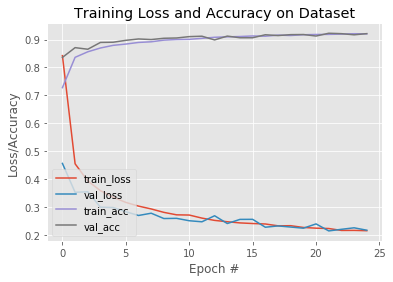

In [10]:
# plot the training loss and accuracy
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()